### Project 1

Project description: 
- Read data into Jupyter notebook, use pandas to import data into a data frame
- preprocess data: explore data, address missing data, categorical data, if there is any, and data scaling. Justify the type of scaling used in this project. 
- train your dataset using all the linear regression models you've learned so far. If your model has a scaling parameter(s) use Grid Search to find the best scaling parameter. Use plots and graphs to help you get a better glimpse of the results. 
- Then use cross validation to find average training and testing score. 
- Your submission should have at least the following regression models: KNN repressor, linear regression, Ridge, Lasso, polynomial regression, SVM both simple and with kernels. 
- Finally find the best repressor for this dataset and train your model on the entire dataset using the best parameters and predict the market price for the test_set.
- submit IPython notebook. Use markdown to provide an inline report for this project.

##### <font color = 'red'> Important note: All the group members should participate in completing this project.  This includes coding, preparing report and testing the models. 

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import NuSVR, SVR, LinearSVR
from sklearn.model_selection import cross_val_score, validation_curve

data = pd.read_csv('bitcoin_dataset.csv')
test = pd.read_csv('test_set.csv')

In [3]:
for col in data.columns[1:]:
    data.rename(columns={col:col[4:]}, inplace = True)

for col in test.columns[1:]:
    test.rename(columns={col:col[4:]}, inplace=True)

In [4]:
print(100*data.isnull().sum().sum() / data.shape[0]) #4% overall nulls in train
print(100*test.isnull().sum().sum() / test.shape[0]) #0% here

3.9573296627666896
0.0


In [5]:
data["Date"] = pd.to_datetime(data["Date"])
data = data.set_index("Date")

In [6]:
sns.set_style("white")

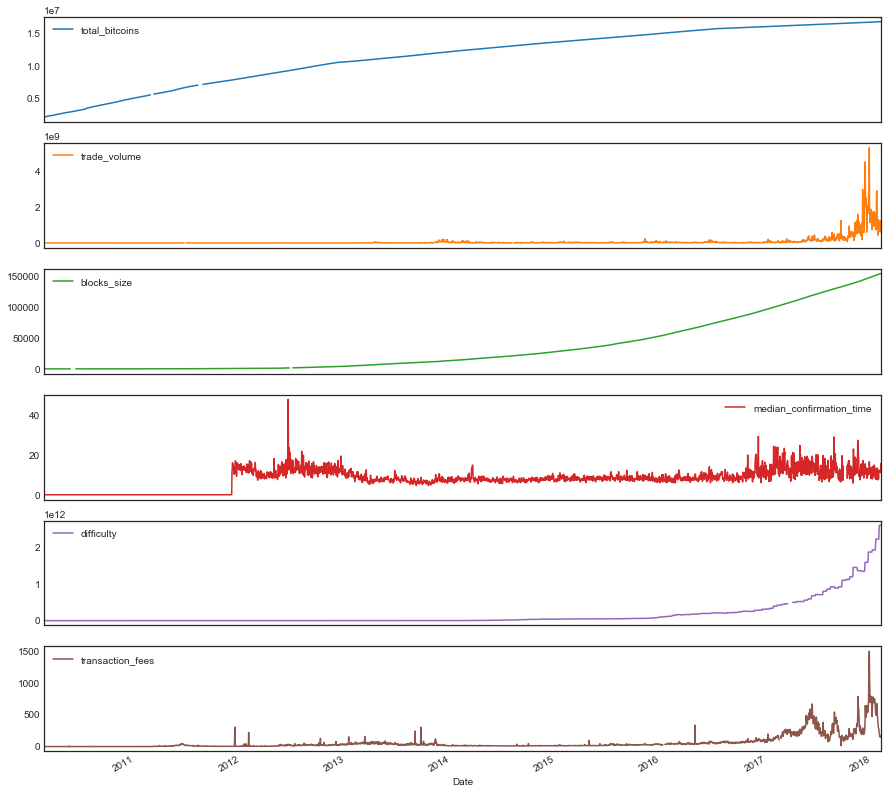

In [7]:
data[["total_bitcoins","trade_volume","blocks_size",
      "median_confirmation_time", "difficulty","transaction_fees"]].plot(subplots=True, figsize=(15, 15)); plt.legend(loc='best')

In [8]:
ColsToImpute = ["total_bitcoins","trade_volume","blocks_size","difficulty","transaction_fees"]
data[ColsToImpute] = data[ColsToImpute].interpolate(method="time")
#Now we only have to impute median_confirmation_time which will be imputed by average
data = data.fillna(data.mean())

In [139]:
cols = data.columns[1:]
hs = {}
for col in cols:
    htemp = np.histogram(data[col], bins=200) #store the histogram
    htemp = htemp[0] / len(data[col]) #get the probabilities
    hs[col] = htemp

In [140]:
len(hs)

22

In [141]:
dplot = np.zeros((22,22)) #matrix to store the KL distance between each combination of column
m = 0
for feat1 in hs:
    n=0
    for feat2 in hs:
        #code to calculate Kullback leibler distance
        dplot[m][n] = np.sum(np.matmul(hs[feat1], np.log((hs[feat1]+1e-5)/(hs[feat2]+1e-5))))
        n = int(n+1)
    m = int(m+1)

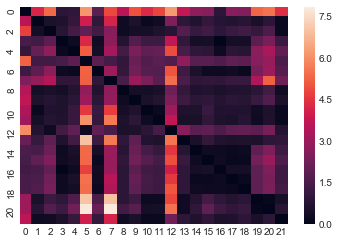

In [142]:
sns.heatmap(dplot)

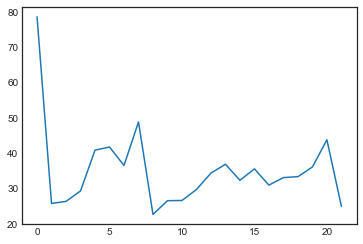

In [143]:
distance_means = np.sum(dplot, axis = 1)
plt.plot(distance_means)

In [144]:
arr = distance_means > np.mean(distance_means)

In [145]:
colsToKeep = []
for num, key in enumerate(hs.keys()):
    if arr[num]:
        colsToKeep.append(key)

colsToKeep.insert(0, "market_price")
colsToKeep

['market_price',
 'total_bitcoins',
 'avg_block_size',
 'n_orphaned_blocks',
 'n_transactions_per_block',
 'median_confirmation_time',
 'cost_per_transaction',
 'n_transactions',
 'output_volume',
 'estimated_transaction_volume']

In [146]:
data = data[colsToKeep]

In [147]:
data.head()

,market_price,total_bitcoins,avg_block_size,n_orphaned_blocks,n_transactions_per_block,median_confirmation_time,cost_per_transaction,n_transactions,output_volume,estimated_transaction_volume
Date,,,,,,,,,,
2010-02-17,0.0,2043200.0,0.000235,0,1.0,0.0,0.0,244,65173.13,36500.0
2010-02-18,0.0,2054650.0,0.000241,0,1.0,0.0,0.0,235,18911.74,7413.0
2010-02-19,0.0,2063600.0,0.000228,0,1.0,0.0,0.0,183,9749.98,700.0
2010-02-20,0.0,2074700.0,0.000218,0,1.0,0.0,0.0,224,11150.03,50.0
2010-02-21,0.0,2085400.0,0.000234,0,1.0,0.0,0.0,218,12266.83,1553.0


In [148]:
df_num = data.diff()
df_num = df_num.dropna()

In [149]:
from sklearn.preprocessing import normalize

train = normalize(df_num)

train = pd.DataFrame(train)

In [150]:
train.columns = data.columns

In [151]:
train = train.set_index(df_num.index.values)

In [152]:
train.head()

,market_price,total_bitcoins,avg_block_size,n_orphaned_blocks,n_transactions_per_block,median_confirmation_time,cost_per_transaction,n_transactions,output_volume,estimated_transaction_volume
2010-02-18,0.0,0.205078,1.099180e-10,0.0,0.0,0.0,0.0,-0.000161,-0.828574,-0.520969
2010-02-19,0.0,0.618925,-9.103390e-10,0.0,0.0,0.0,0.0,-0.003596,-0.633569,-0.464229
2010-02-20,0.0,0.990462,-8.369853e-10,0.0,0.0,0.0,0.0,0.003658,0.124928,-0.058000
2010-02-21,0.0,0.985030,1.429123e-09,0.0,0.0,0.0,0.0,-0.000552,0.102811,0.138365
2010-02-22,0.0,0.427423,5.030782e-09,0.0,0.0,0.0,0.0,0.001442,0.673255,0.603353


In [153]:
trainObs = list(range(0, int(0.7 * train.shape[0])))
testObs = list(range(int(0.7 * train.shape[0]), train.shape[0]))

In [154]:
btc_train = train.iloc[trainObs]
btc_test = train.iloc[testObs]

In [155]:
X_train = btc_train[btc_train.columns[1:len(btc_train.columns)]]
y_train = btc_train["market_price"]
X_test = btc_test[btc_test.columns[1:len(btc_test.columns)]]
y_test = btc_test["market_price"]

In [156]:
linreg = LinearRegression().fit(X_train, y_train)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

linear model coeff (w): [ -3.66705400e-06   1.03344014e+02  -3.03188251e+00  -3.79878002e-04
   2.99667822e-01   1.45559895e+00   1.39461729e-05   1.07679456e-06
   9.05884577e-06]
linear model intercept (b): -0.000
R-squared score (training): 0.266
R-squared score (test): 0.020


In [157]:
svr = SVR(kernel = 'linear', epsilon = 0.01)
svr.fit(X_train, y_train)
svr.score(X_test, y_test)

-0.28164433444672632

In [131]:
print('Lasso regression: effect of alpha regularization\n\
parameter on number of features kept in final model\n')

for alpha in [1,5,10,20,50,100]:
    linlasso = Lasso(alpha, max_iter = 10000).fit(X_train, y_train)
    r2_train = linlasso.score(X_train, y_train)
    r2_test = linlasso.score(X_test, y_test)
    
    print('Alpha = {:.2f}\nFeatures kept: {}, r-squared training: {:.2f}, \
r-squared test: {:.2f}\n'
         .format(alpha, np.sum(linlasso.coef_ != 0), r2_train, r2_test))

Lasso regression: effect of alpha regularization
parameter on number of features kept in final model

Alpha = 1.00
Features kept: 0, r-squared training: 0.00, r-squared test: -0.00

Alpha = 5.00
Features kept: 0, r-squared training: 0.00, r-squared test: -0.00

Alpha = 10.00
Features kept: 0, r-squared training: 0.00, r-squared test: -0.00

Alpha = 20.00
Features kept: 0, r-squared training: 0.00, r-squared test: -0.00

Alpha = 50.00
Features kept: 0, r-squared training: 0.00, r-squared test: -0.00

Alpha = 100.00
Features kept: 0, r-squared training: 0.00, r-squared test: -0.00

